# **CASE STUDY: SPARK FUNDS**
Importing the required libraries


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



Creating dataframes for the given data files

The files are converted to respective DataFrames i.e. 

*   **companies**
*   **rounds_2**
*   **mapping** 





[Link to GitHub Repository for Data Files used!]( https://github.com/ChitrangJ/Case-Study)

In [10]:
from google.colab import files
upload=files.upload()
upload1=files.upload()
upload2=files.upload()

companies=pd.read_csv("companies.txt",sep='\t',encoding="ISO-8859-1")
rounds_2=pd.read_csv("rounds2.csv",encoding="ISO-8859-1")
mapping=pd.read_csv("mapping.csv")


Saving companies.txt to companies.txt


Saving rounds2.csv to rounds2.csv


Saving mapping.csv to mapping.csv


# CHECKPOINT-1: **DATA CLEANING**


DataFrame[**companies**]

We can see that this DataFrame contains some corrupt values or the encoded ones,For eg. **Ä°novatiff Reklam ve TanÄ±tÄ±m Hizmetleri Tic**.

So we need to handle these errors before proceeding further.

In [18]:
companies.tail()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
66363,/organization/zznode-science-and-technology-co...,ZZNode Science and Technology,http://www.zznode.com,Enterprise Software,operating,CHN,22,Beijing,Beijing,NaN
66364,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,operating,HRV,15,Split,Split,13-05-2012
66365,/organization/eron,ÃERON,http://www.aeron.hu/,NaN,operating,NaN,NaN,NaN,NaN,01-01-2011
66366,/organization/asys-2,Ãasys,http://www.oasys.io/,Consumer Electronics|Internet of Things|Teleco...,operating,USA,CA,SF Bay Area,San Francisco,01-01-2014
66367,/organization/novatiff-reklam-ve-tantm-hizmetl...,Ä°novatiff Reklam ve TanÄ±tÄ±m Hizmetleri Tic,http://inovatiff.com,Consumer Goods|E-Commerce|Internet,operating,NaN,NaN,NaN,NaN,NaN


The given files contain few values which are encrypted to Latin-1, so as to handle those values we have used **Enoding** and **Decoding**.

In [15]:
companies['permalink'] = companies['permalink'].str.encode('ascii', 'ignore').str.decode('ascii','ignore')
rounds_2['company_permalink'] = rounds_2['company_permalink'].str.encode('ascii', 'ignore').str.decode('ascii','ignore')
rounds_2.tail()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
114944,/organization/zzzzapp-com,/funding-round/8f6d25b8ee4199e586484d817bceda05,convertible_note,NaN,01-03-2014,41313.0
114945,/ORGANIZATION/ZZZZAPP-COM,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,01-05-2013,32842.0
114946,/organization/eron,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,01-08-2014,NaN
114947,/ORGANIZATION/ASYS-2,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,01-01-2015,18192.0
114948,/organization/novatiff-reklam-ve-tantm-hizmetl...,/funding-round/af942869878d2cd788ef5189b435ebc4,grant,NaN,01-10-2013,14851.0


We are well aware that Python is case sensitive language, so we will convert the sentence case of 'permalink' and 'company_permalink' to lowercase respectively,to main uniform values throughout.

In [17]:
companies['permalink']=companies['permalink'].map(lambda x:x.lower())
rounds_2['company_permalink']=rounds_2['company_permalink'].map(lambda x:x.lower())
rounds_2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


Since the sentence case has been adjusted , we can now find unique values in the **rounds_2** and **companies**

In [19]:
unq1=companies['permalink'].nunique(dropna=True)
print('Unique values in companies: ',unq1)

Unique values in companies:  66368


In [20]:
unq2=rounds_2['company_permalink'].nunique(dropna=True)
print('Unique values in rounds_2: ',unq2)

Unique values in rounds_2:  66368


In the companies data frame, which column can be used as the unique key for each company? 

Write the name of the column.
Ans-->  **'permalink'** , as it contains all unique values.

In [23]:
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/organization/colizer,Blink,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


Are there any companies in the **rounds2** file which are not present in companies?

Answer yes or no: Y/N

In [26]:
unique_vals=set(rounds_2['company_permalink']).intersection(set(companies['permalink']))
print("Unique Values: ",len(unique_vals))

Unique Values:  66368


Ans--> **N**

No. of unique companies in **rounds_2** = No. of unique companies in **companies** = Intersection of two created sets(**66368**)

Before merging rename column '**company_permalink**' to '**permalink**' in rounds_2


In [0]:
rounds_2=rounds_2.rename(columns={'company_permalink':'permalink'})

Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. 

Name the merged frame **master_frame**.

How many observations are present in **master_frame**?Ans-->  (114949, 15)  

In [28]:
master_frame = pd.merge(companies, rounds_2, how='right', on=['permalink'])
print(master_frame.shape)


(114949, 15)


Now as we don't require the extra columns such as 'city', 'status', and never the less, we will drop these columns from our dataframe for effecient and elegant analysis.

In [29]:
master_frame = master_frame.drop(['funding_round_code', 'funding_round_permalink', 'funded_at', 'homepage_url',
                                 'state_code', 'region', 'city', 'founded_at','status'], axis = 1)
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,venture,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,venture,NaN
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,seed,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN,venture,3406878.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,venture,2000000.0


# CHECKPOINT-2: **FUNDING TYPE ANALYSIS**

Before moving further, we identified and handled the potential NULL values which can cause discrepancy in Data Analysis.

In [30]:
master_frame = master_frame[~(master_frame['raised_amount_usd'].isnull() | master_frame['country_code'].isnull() |
                             master_frame['category_list'].isnull())]
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,venture,10000000.0
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,seed,700000.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,venture,2000000.0
6,/organization/01games-technology,01Games Technology,Games,HKG,undisclosed,41250.0
7,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,CAN,seed,43360.0


Converting **raised_amount_usd** to Million USD for easier interpretation of results.

In [0]:
master_frame['raised_amount_usd']=master_frame['raised_amount_usd']/1000000

Calculation of **Average Funding amount** for each type using '**groupby**' function.

In [32]:
df_by_type=master_frame.groupby('funding_round_type')
round(df_by_type['raised_amount_usd'].mean(),2)

funding_round_type
angel                      0.97
convertible_note           1.34
debt_financing            17.17
equity_crowdfunding        0.51
grant                      4.51
non_equity_assistance      0.48
post_ipo_debt            169.45
post_ipo_equity           66.08
private_equity            73.94
product_crowdfunding       1.35
secondary_market          84.44
seed                       0.75
undisclosed               15.89
venture                   11.72
Name: raised_amount_usd, dtype: float64

Most representative funding type: '**venture**'

In [33]:
master_frame['funding_round_type'].value_counts()

venture                  47809
seed                     21095
debt_financing            6506
angel                     4400
grant                     1939
private_equity            1820
undisclosed               1345
convertible_note          1320
equity_crowdfunding       1128
post_ipo_equity            598
product_crowdfunding       330
post_ipo_debt              151
non_equity_assistance       60
secondary_market            28
Name: funding_round_type, dtype: int64

Removing the unwanted data as we just want to analyse on the basis of most representative fundning type i.e. **venture**.

In [34]:
graph_frame=master_frame                   # Will be considered in plotting of graphs 
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']
master_frame.head(3)

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,venture,10.000000
4,/organization/0-6-com,0-6.com,Curated Web,CHN,venture,2.000000
8,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,CAN,venture,0.719491


# CHECKPOINT-3: **COUNTRY ANALYSIS** 

Primarily segregating the top 9 countries on the basis of highest total funding.

We will use the concept of '**pivot_tables**' for this analysis.

In [35]:
top9=master_frame.pivot_table(values='raised_amount_usd',index='country_code',aggfunc='sum')
top9=top9.sort_values(by='raised_amount_usd',ascending=False)
top9=top9[:9]
print(top9)

              raised_amount_usd
country_code                   
USA               420068.029342
CHN                39338.918773
GBR                20072.813004
IND                14261.508718
CAN                 9482.217668
FRA                 7226.851352
ISR                 6854.350477
DEU                 6306.921981
JPN                 3167.647127


On analysis of countries,top 3 countries on the basis of **English** as an official language are:

1.   **USA**
2.   **GBR**
3.   **IND**


Filtering master_frame with only USA, GBR and IND country_codes.[Top 3 English speaking countries]

In [36]:
master_frame = master_frame[(master_frame['country_code']=='USA') | (master_frame['country_code']=='GBR') | (master_frame['country_code']=='IND')]
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,venture,10.0
10,/organization/0xdata,H2O.ai,Analytics,USA,venture,20.0
11,/organization/0xdata,H2O.ai,Analytics,USA,venture,1.7
12,/organization/0xdata,H2O.ai,Analytics,USA,venture,8.9
22,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,USA,venture,5.0


# CHECKPOINT-4: **SECTOR ANALYSIS-1**



**Extract** the primary sector of each category list from the **category_list** column

In [37]:
master_frame['category_list']=master_frame['category_list'].map(lambda x:str(x).split('|')[0])
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,venture,10.0
10,/organization/0xdata,H2O.ai,Analytics,USA,venture,20.0
11,/organization/0xdata,H2O.ai,Analytics,USA,venture,1.7
12,/organization/0xdata,H2O.ai,Analytics,USA,venture,8.9
22,/organization/1-mainstream,1 Mainstream,Apps,USA,venture,5.0


Mapping the primary sectors of each company with one of the 8 main sectors using **melt()** function.

And also merging of obtained dataframe and master_frame.

In [38]:
mapping=pd.melt(mapping,id_vars='category_list',value_vars=['Manufacturing','Automotive & Sports',
                                                              'Cleantech / Semiconductors','Entertainment',
                                                             'Health','News, Search and Messaging','Others',
                                                             'Social, Finance, Analytics, Advertising'],var_name='main_sector')
ind_drop = mapping[mapping['value'].apply(lambda x: x==0)].index
mapping=mapping.drop(ind_drop)
mapping=mapping.drop('value',axis=1)
master_frame=pd.merge(master_frame,mapping,how='left',on='category_list')
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,main_sector
0,/organization/-fame,#fame,Media,IND,venture,10.0,Entertainment
1,/organization/0xdata,H2O.ai,Analytics,USA,venture,20.0,"Social, Finance, Analytics, Advertising"
2,/organization/0xdata,H2O.ai,Analytics,USA,venture,1.7,"Social, Finance, Analytics, Advertising"
3,/organization/0xdata,H2O.ai,Analytics,USA,venture,8.9,"Social, Finance, Analytics, Advertising"
4,/organization/1-mainstream,1 Mainstream,Apps,USA,venture,5.0,"News, Search and Messaging"


Removal of all the NULL values from column = main_sector, if any, so as to obtain efficient data.

In [0]:
master_frame=master_frame[~(master_frame.main_sector.isnull())]

# CHECKPOINT-5: **SECTOR ANALYSIS-2**

Creating 3 separate Dataframes for each country respectively keeping in mind 2 constraints:



1.   **Funding type 'Venture'**
2.   **Investments range of 5-15 M USD**



In [45]:
D1=master_frame[(master_frame['country_code']=='USA') & (master_frame['raised_amount_usd'] >= 5) 
                & (master_frame['raised_amount_usd'] <= 15)]
D_1=D1[['main_sector','raised_amount_usd']].groupby('main_sector').agg(['count','sum']).rename(columns={'count':'Total_count','sum':'Total_sum'})
D1=D1.merge(D_1,how='left',on='main_sector')
D1.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,main_sector,"(raised_amount_usd, Total_count)","(raised_amount_usd, Total_sum)"
0,/organization/0xdata,H2O.ai,Analytics,USA,venture,8.900000,"Social, Finance, Analytics, Advertising",2714,23807.376964
1,/organization/1-mainstream,1 Mainstream,Apps,USA,venture,5.000000,"News, Search and Messaging",1582,13959.567428
2,/organization/128-technology,128 Technology,Service Providers,USA,venture,11.999347,Others,2950,26321.007002
3,/organization/1366-technologies,1366 Technologies,Manufacturing,USA,venture,15.000000,Manufacturing,799,7258.553378
4,/organization/1366-technologies,1366 Technologies,Manufacturing,USA,venture,5.000000,Manufacturing,799,7258.553378


In [42]:
D2=master_frame[(master_frame['country_code']=='GBR') & (master_frame['raised_amount_usd'] >= 5) 
                & (master_frame['raised_amount_usd'] <= 15)]
D_2=D2[['main_sector','raised_amount_usd']].groupby('main_sector').agg(['count','sum']).rename(columns={'count':'Total_count','sum':'Total_sum'})
D2=D2.merge(D_2,how='left',on='main_sector')
D2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,main_sector,"(raised_amount_usd, Total_count)","(raised_amount_usd, Total_sum)"
0,/organization/365scores,365Scores,Android,GBR,venture,5.500000,"Social, Finance, Analytics, Advertising",133,1089.404014
1,/organization/7digital,7digital,Content Creators,GBR,venture,8.468328,Entertainment,56,482.784687
2,/organization/7digital,7digital,Content Creators,GBR,venture,10.000000,Entertainment,56,482.784687
3,/organization/90min,90min,Media,GBR,venture,15.000000,Entertainment,56,482.784687
4,/organization/90min,90min,Media,GBR,venture,5.800000,Entertainment,56,482.784687


In [43]:
D3=master_frame[(master_frame['country_code']=='IND') & (master_frame['raised_amount_usd'] >= 5) 
                & (master_frame['raised_amount_usd'] <= 15)]
D_3=D3[['main_sector','raised_amount_usd']].groupby('main_sector').agg(['count','sum']).rename(columns={'count':'Total_count','sum':'Total_sum'})
D3=D3.merge(D_3,how='left',on='main_sector')
D3.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,main_sector,"(raised_amount_usd, Total_count)","(raised_amount_usd, Total_sum)"
0,/organization/-fame,#fame,Media,IND,venture,10.000000,Entertainment,33,280.830000
1,/organization/21diamonds-india,21Diamonds,E-Commerce,IND,venture,6.369507,Others,110,1013.409507
2,/organization/a-little-world,A LITTLE WORLD,Finance,IND,venture,6.410000,"Social, Finance, Analytics, Advertising",60,550.549550
3,/organization/adlabs-imagica,Adlabs Imagica,Entertainment,IND,venture,8.180000,Entertainment,33,280.830000
4,/organization/agile,Agile,Finance,IND,venture,5.740000,"Social, Finance, Analytics, Advertising",60,550.549550


####**Total number of Investments(Country wise)**

In [46]:
print('Total number of Investements in USA: ',D1.raised_amount_usd.count())
print('Total number of Investements in GBR: ',D2.raised_amount_usd.count())
print('Total number of Investements in IND: ',D3.raised_amount_usd.count())

Total number of Investements in USA:  12012
Total number of Investements in GBR:  619
Total number of Investements in IND:  328


####**Total amount of Investments(Country wise)**

In [47]:
print('Total amount of Investements in USA: ',round(D1.raised_amount_usd.sum(),2))
print('Total amount of Investements in GBR: ',round(D2.raised_amount_usd.sum(),2))
print('Total amount of Investements in IND: ',round(D3.raised_amount_usd.sum(),2))

Total amount of Investements in USA:  107318.29
Total amount of Investements in GBR:  5365.23
Total amount of Investements in IND:  2949.54


####**TOP 3 SECTOR,INVESTMENT AND TOP 2 COMPANY** Analysis:  


####**USA**

In [49]:
D_1

raised_amount_usd              
                                              Total_count     Total_sum
main_sector                                                            
Automotive & Sports                                   167   1454.104361
Cleantech / Semiconductors                           2300  21206.628192
Entertainment                                         591   5099.197982
Health                                                909   8211.859357
Manufacturing                                         799   7258.553378
News, Search and Messaging                           1582  13959.567428
Others                                               2950  26321.007002
Social, Finance, Analytics, Advertising              2714  23807.376964

In [53]:
top=D1[D1['main_sector']=='Others']
top=top.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
top=top.sort_values(by='raised_amount_usd',ascending=False)
top.head(1)


,raised_amount_usd
name,
Virtustream,64.3


In [54]:
second=D1[D1['main_sector']=='Social, Finance, Analytics, Advertising']
second=second.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
second=second.sort_values(by='raised_amount_usd',ascending=False)
second.head(1)

,raised_amount_usd
name,
SST Inc. (Formerly ShotSpotter),67.933006


####**GBR**

In [55]:
D_2

raised_amount_usd             
                                              Total_count    Total_sum
main_sector                                                           
Automotive & Sports                                    16   167.051565
Cleantech / Semiconductors                            128  1150.139665
Entertainment                                          56   482.784687
Health                                                 24   214.537510
Manufacturing                                          42   361.940335
News, Search and Messaging                             73   615.746235
Others                                                147  1283.624289
Social, Finance, Analytics, Advertising               133  1089.404014

In [56]:
top=D2[D2['main_sector']=='Others']
top=top.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
top=top.sort_values(by='raised_amount_usd',ascending=False)
top.head(1)

,raised_amount_usd
name,
Electric Cloud,37.0


In [57]:
second=D2[D2['main_sector']=='Social, Finance, Analytics, Advertising']
second=second.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
second=second.sort_values(by='raised_amount_usd',ascending=False)
second.head(1)

,raised_amount_usd
name,
Celltick Technologies,37.5


####**IND**

In [58]:
D_3

raised_amount_usd             
                                              Total_count    Total_sum
main_sector                                                           
Automotive & Sports                                    13   136.900000
Cleantech / Semiconductors                             20   165.380000
Entertainment                                          33   280.830000
Health                                                 19   167.740000
Manufacturing                                          21   200.900000
News, Search and Messaging                             52   433.834545
Others                                                110  1013.409507
Social, Finance, Analytics, Advertising                60   550.549550

In [59]:
top=D3[D3['main_sector']=='Others']
top=top.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
top=top.sort_values(by='raised_amount_usd',ascending=False)
top.head(1)

,raised_amount_usd
name,
FirstCry.com,39.0


In [60]:
second=D3[D3['main_sector']=='News, Search and Messaging']
second=second.pivot_table(values='raised_amount_usd',index='name',aggfunc='sum')
second=second.sort_values(by='raised_amount_usd',ascending=False)
second.head(1)

,raised_amount_usd
name,
GupShup,33.0


# CHECKPOINT-6: **PLOTS**

Plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type.

This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

In [0]:
x=graph_frame[graph_frame['funding_round_type'].isin(['venture','seed','private_equity'])]

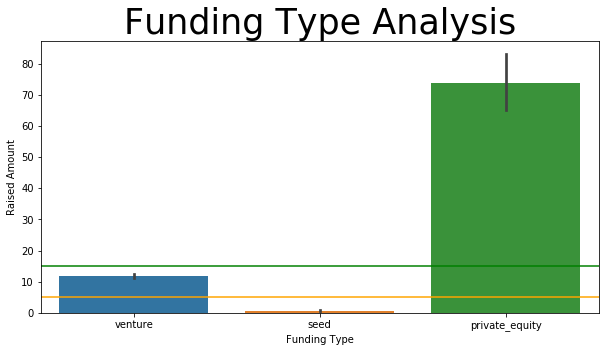

In [69]:
plt.figure(figsize=(10,5))
g=sns.barplot(x='funding_round_type', y='raised_amount_usd', data=x)
g.set(xlabel='Funding Type', ylabel='Raised Amount')
g.set_title('Funding Type Analysis',fontsize =35)
plt.axhline(5, color='Orange')
plt.axhline(15, color='Green')
plt.show()

Plot showing the **Top 9 countries** against the total amount of investments of funding type '**venture**'.

In [0]:
x1=graph_frame[graph_frame['country_code'].isin(top9.index)]

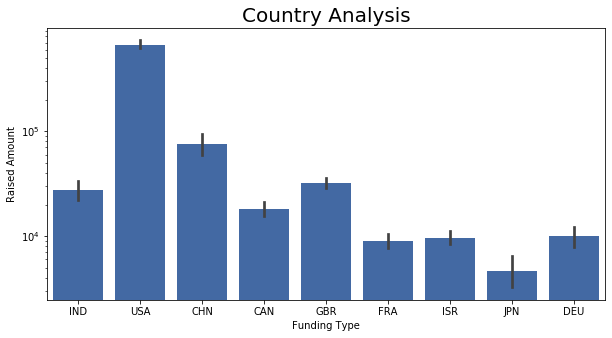

In [64]:
plt.figure(figsize=(10,5))
c=sns.barplot(x='country_code', y='raised_amount_usd', data=x1, estimator=np.sum,color=(0.2, 0.4, 0.7, 0.6))
c.set_yscale('log')
c.set(xlabel='Funding Type', ylabel='Raised Amount')
c.set_title('Country Analysis',fontsize =20)
plt.show()

Plot showing the **number of investments** in the top 3 sectors of the top 3 countries on one chart

In [0]:
D=D1[D1['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])]
D=D.append(D2[D2['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors'])], ignore_index=True)
D=D.append(D3[D3['main_sector'].isin(['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging'])], ignore_index=True)

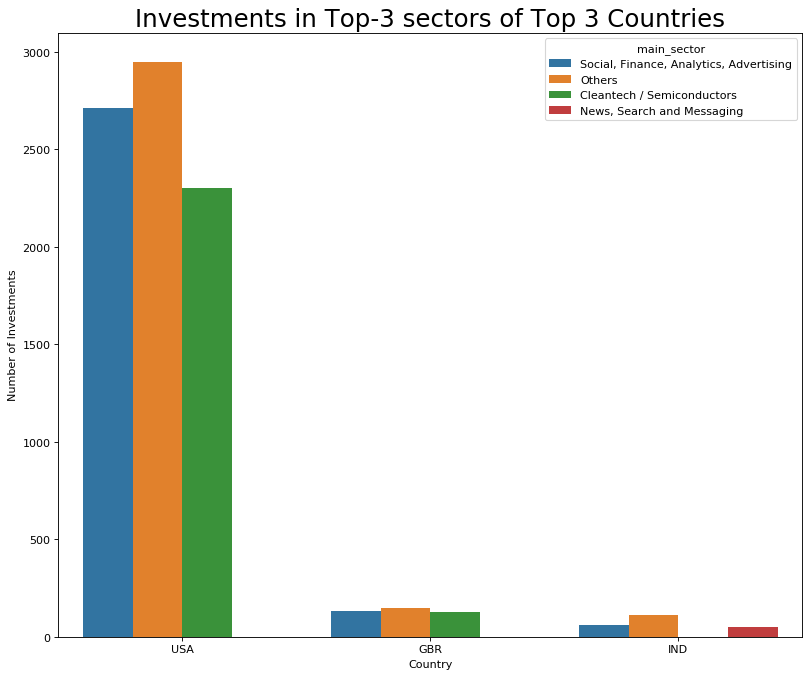

In [68]:
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='r')

s=sns.barplot(x='country_code', y='raised_amount_usd', hue="main_sector", data=D,estimator=lambda x:len(x))
s.set(xlabel='Country', ylabel='Number of Investments')
s.set_title('Investments in Top-3 sectors of Top 3 Countries',fontsize =22)
plt.show() 